# Toy model superposition

In [1]:
%pip install setuptools ipykernel transformer-lens nbformat plotly einops ipywidgets matplot numpy


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from typing import Optional
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass

@dataclass
class Config:
    n_features: int
    n_hidden: int
    n_instances: int

class ReluModel(nn.Module):
    def __init__(
        self, 
        config: Config,
        feature_prob: Optional[torch.Tensor] = None,
        importance: Optional[torch.Tensor] = None,
        name: str = "Relu",
    ) -> None:
        super().__init__()
        self.config = config
        self.W = nn.Parameter(torch.empty((config.n_instances, config.n_features, config.n_hidden)))
        nn.init.xavier_normal_(self.W)
        self.b = nn.Parameter(torch.zeros((config.n_instances, config.n_features)))
        
        if feature_prob is None:
            feature_prob = torch.ones(())
        
        self.feature_prob = feature_prob
        
        if importance is None:
            importance = torch.ones(())
        
        self.importance = importance
        self.name = name
    
    def forward(self, features: torch.Tensor) -> torch.Tensor:
        # features [..., n_instances, n_features]
        # W: [n_instances, n_features, n_hidden]
        hidden = torch.einsum("...if,ifh->...ih", features, self.W)
        out = torch.einsum("...ih,ifh->...if", hidden, self.W)
        out = out + self.b
        return F.relu(out)
    
    def generate_batch(self, n_batch: int) -> torch.Tensor:
        ## generate features with values in range [0, 1] having shape [n_batch, n_instances, n_features]
        return (torch.rand(size=(n_batch, self.config.n_instances, self.config.n_features)) - self.feature_prob).ceil().abs()

torch.set_default_device("mps")

### Test models

Lightweight tests to check if the models are outputing correct shape on forward pass or not.

In [ ]:
from typing import List

def should_have_correct_output_shape(cls, cfg: Config, exp_shape: List[int]) -> None:
    model = cls(cfg)
    x = model.generate_batch(1)
    y = model.forward(x[0])
    
    assert torch.Size(exp_shape) == y.shape, f"shape does not match {torch.Size(exp_shape)} != {y.shape}"

In [ ]:
cfg = Config(n_features=5, n_hidden=2, n_instances=10)

should_have_correct_output_shape(ReluModel, cfg, [cfg.n_instances, cfg.n_features])

### Loss function
$$L = \sum_{x} \sum_{i} I_i(x_i - x_i^{\prime})^2$$

## Model training

In [5]:
import time
import plotly.express as px
import einops
from tqdm.notebook import trange
import numpy as np

def linear_lr(step, steps):
  return (1 - (step / steps))

def constant_lr(*_):
  return 1.0

def cosine_decay_lr(step, steps):
  return np.cos(0.5 * np.pi * step / (steps - 1))

def optimize(model, 
             render=False, 
             n_batch=1024,
             steps=10_000,
             print_freq=100,
             lr=1e-3,
             lr_scale=constant_lr,
             hooks=[]):
  cfg = model.config

  opt = torch.optim.AdamW(list(model.parameters()), lr=lr)

  losses = []
  start = time.time()
  with trange(steps) as t:
    for step in t:
      step_lr = lr * lr_scale(step, steps)
      for group in opt.param_groups:
        group['lr'] = step_lr
      opt.zero_grad(set_to_none=True)
      batch = model.generate_batch(n_batch)
      out = model(batch)
      error = (model.importance*(batch.abs() - out)**2)
      loss = einops.reduce(error, 'b i f -> i', 'mean').sum()
      losses.append(loss.item())
      loss.backward()
      opt.step()
    
      if hooks:
        hook_data = dict(model=model,
                         step=step, 
                         opt=opt,
                         error=error,
                         loss=loss,
                         lr=step_lr)
        for h in hooks:
          h(hook_data)
      if step % print_freq == 0 or (step + 1 == steps):
        t.set_postfix(
            loss=loss.item() / cfg.n_instances,
            lr=step_lr,
        )
  return losses

config = Config(
    n_features = 5,
    n_hidden = 2,
    n_instances = 10,
)

relu_model = ReluModel(
    config=config,
    # Exponential feature importance curve from 1 to 1/100
    importance = (0.9**torch.arange(config.n_features))[None, :],
    # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
    feature_prob = (20 ** -torch.linspace(0, 1, config.n_instances))[:, None]
)

relu_model_losses = optimize(relu_model)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# px.line(linear_model_losses, labels={"x": "Epoch", "y": "Loss"}, title=f"Linear model loss")

NameError: name 'linear_model_losses' is not defined

In [7]:
px.line(relu_model_losses, labels={"x": "Epoch", "y": "Loss"}, title=f"ReLU model loss")

## Visualization and analysis of superposition

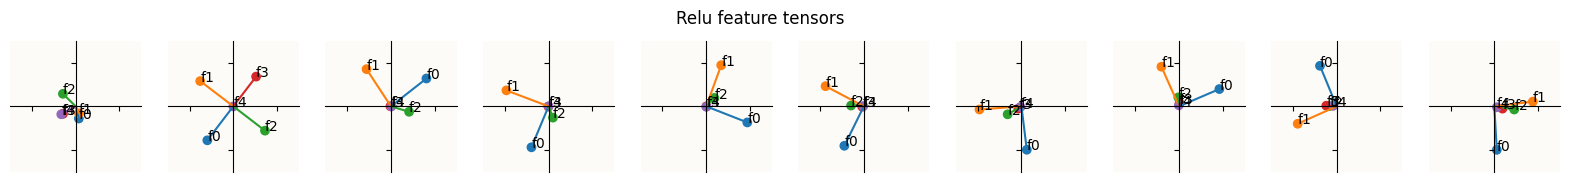

In [9]:
import collections
import matplotlib.pyplot as plt
from matplotlib import colors  as mcolors
from matplotlib import collections  as mc
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
  
def plot_intro_diagram(model):
  cfg = model.config
  WA = model.W.detach()
  sel = range(cfg.n_instances) # can be used to highlight specific sparsity levels
  
  fig, axs = plt.subplots(1, len(sel), figsize=(2*len(sel), 2))
  for i, ax in zip(sel, axs):
      # features shape: [n_features, n_hidden]
      # each row in this tensor represents a feature packed in lower dimension
      features = WA[i].cpu().detach().numpy()
      colors = [mcolors.to_rgba(c) for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]
      x_data, y_data = features[:, 0], features[:, 1]
      ax.scatter(x_data, y_data, c=colors[0: len(x_data)])
      
      for f in range(cfg.n_features):
        ax.annotate(f"f{f}", (features[f,0], features[f,1]))

      ax.set_aspect('equal')
      # connect line from origin to scatter point
      ax.add_collection(mc.LineCollection(np.stack((np.zeros_like(features), features), axis=1), colors=colors))
      
      # zoom in till x_lim, y_lim = ±1.5
      z = 1.5
      ax.set_facecolor('#FCFBF8')
      ax.set_xlim((-z,z))
      ax.set_ylim((-z,z))
      ax.tick_params(left = True, right = False, labelleft = False, labelbottom = False, bottom = True)
      
      # display xy axes with origin at center of the figure
      for spine in ['top', 'right']:
          ax.spines[spine].set_visible(False)
      for spine in ['bottom','left']:
          ax.spines[spine].set_position('center')
  
  fig.suptitle(f"{model.name} feature tensors")
  plt.show()

def model_feature_norm(model, feature, instance):
  return torch.linalg.vector_norm(model.W[instance, feature]).cpu().detach().numpy()

def plot_norm_diff(models):
  fig = make_subplots(
    rows=len(models), 
    cols=models[0].config.n_features,
    subplot_titles=[f"{model.name}_f{feat+1}" for model in models for feat in range(model.config.n_features)],
  )
  for m, model in enumerate(models):
    for feat in range(model.config.n_features):
      data = []
      for i in range(model.config.n_instances):
        data.append(model_feature_norm(model, feat, i))
  
      fig.append_trace(
        go.Scatter(y=data, x=np.arange(len(data)), name=f"{model.name}_f{feat+1}"),
        row=m+1, col=feat+1
      )
  
  fig.update_layout(title_text="Feature norm vs sparsity")
  fig.show()

def plot_feat_intersection(model):
  # data: [instances, features]
  data = collections.defaultdict(list)
  
  for i in range(model.config.n_instances):
    W = model.W.cpu().detach()
    for f1 in range(model.config.n_features):
      for f2 in range(f1+1, model.config.n_features):
        dot = W[i,f1].vdot(W[i,f2])
        data[f"f{f1}.f{f2}"].append(dot**2)
  
  fig = px.line(data, labels={"x": "sparsity", "y": "dot product"}, title=f"{model.name} model feature dot product vs sparsity")
  fig.show()

plot_intro_diagram(relu_model)
plot_feat_intersection(relu_model)

### Observations:
1. Linear model cannot recover the original input $x$ as $W$ tensor is suppressed down to zero. All its features disappear as sparsity increases.
2. Relu model on the other hand represents its feature vectors from $n$ dimensions to $m$ dimensions with minimal amount of loss of information. Even though the $m$ space is smaller, it is still able to recover them because features are pairwise orthogonal.

### Mathematical analysis

Adding a RELU unit introduces superposition. Why ?
> Intuitive answer - there is a balance of two competing forces
1. Feature benefit
2. Interference


In [10]:
config = Config(
    n_features = 100,
    n_hidden = 20,
    n_instances = 20,
)

relu_model = ReluModel(
    config=config,
    # Exponential feature importance curve from 1 to 1/100
    importance = (100 ** -torch.linspace(0, 1, config.n_features))[None, :],
    # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
    feature_prob = (20 ** -torch.linspace(0, 1, config.n_instances))[:, None]
)

In [ ]:
optimize(relu_model)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def render_features(model, which=np.s_[:]):
  cfg = model.config
  W = model.W.detach()
  W_norm = W / (1e-5 + torch.linalg.norm(W, 2, dim=-1, keepdim=True))

  interference = torch.einsum('ifh,igh->ifg', W_norm, W)
  interference[:, torch.arange(cfg.n_features), torch.arange(cfg.n_features)] = 0

  polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()
  norms = torch.linalg.norm(W, 2, dim=-1).cpu()

  WtW = torch.einsum('sih,soh->sio', W, W).cpu()

  # width = weights[0].cpu()
  # x = torch.cumsum(width+0.1, 0) - width[0]
  x = torch.arange(cfg.n_features).cpu()
  width = 0.9

  which_instances = np.arange(cfg.n_instances)[which]
  fig = make_subplots(rows=len(which_instances),
                      cols=2,
                      shared_xaxes=True,
                      vertical_spacing=0.02,
                      horizontal_spacing=0.1)
  for (row, inst) in enumerate(which_instances):
    fig.add_trace(
        go.Bar(x=x, 
              y=norms[inst],
              marker=dict(
                  color=polysemanticity[inst],
                  cmin=0,
                  cmax=1
              ),
              width=width,
        ),
        row=1+row, col=1
    )
    data = WtW[inst].numpy()
    fig.add_trace(
        go.Image(
            z=plt.cm.coolwarm((1 + data)/2, bytes=True),
            colormodel='rgba256',
            customdata=data,
            hovertemplate='''\
In: %{x}
Out: %{y}
Weight: %{customdata:0.2f}
'''            
        ),
        row=1+row, col=2
    )

  fig.add_vline(
    x=(x[cfg.n_hidden-1]+x[cfg.n_hidden])/2, 
    line=dict(width=0.5),
    col=1,
  )
    
  # fig.update_traces(marker_size=1)
  fig.update_layout(showlegend=False, 
                    width=600,
                    height=100*len(which_instances),
                    margin=dict(t=0, b=0))
  fig.update_xaxes(visible=False)
  fig.update_yaxes(visible=False)
  return fig

In [ ]:
fig = render_features(relu_model, np.s_[::2])
fig.update_layout()